# Finding the Capital Market Line

###### This notebook shows how to compute the capital market line, and hence finding portfolios with maximal sharpe ratio that matches the risk free rate (rf). First, we load stocks data by using zipline load_bars_from_yahoo function. Secondly, we find the efficient frontier by using `cvxopt` library, as shown in the <a href="http://blog.quantopian.com/markowitz-portfolio-optimization-2/">quantopian blog on portfolio optimizations</a> <br></br> Then, we find the efficient frontier function by using spline interpolation, and finding the tangent line that passes throw rf, as shown in the <a href="https://github.com/yhilpisch/py4fi/blob/master/ipython/11_Statistics_a.ipynb/">tutorial about market line from Python for Finance book</a> <br></br>

###  Importing important modules

In [49]:
import numpy as np
import pandas as pd
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

###### Getting stocks data

In [50]:
from zipline.utils.factory import load_bars_from_yahoo
start = datetime(2011, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2013, 1, 1, 0, 0, 0, 0, pytz.utc)

data = load_bars_from_yahoo(stocks=['IBM', 'GLD', 'XOM', 'AAPL', 
                                    'MSFT', 'TLT', 'SHY', 'AA'],
                            start=start, end=end)

IBM
GLD
XOM
AAPL
MSFT
TLT
SHY
AA


###### Show normalized time series data

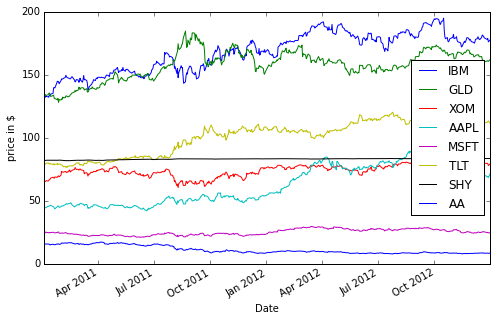

In [51]:
data.loc[:, :, 'price'].plot(figsize=(8,5))
plt.ylabel('price in $')

In [52]:
prices = data.loc[:, :, 'price']
returnsOfStocks = prices.pct_change().dropna()
print(returnsOfStocks);

                                IBM       GLD       XOM      AAPL      MSFT  \
Date                                                                          
2011-01-04 00:00:00+00:00  0.001085 -0.023551  0.004695  0.005219  0.003931   
2011-01-05 00:00:00+00:00 -0.003996 -0.002820 -0.002670  0.008180 -0.003204   
2011-01-06 00:00:00+00:00  0.010949 -0.004019  0.006426 -0.000808  0.029286   
2011-01-07 00:00:00+00:00 -0.004911 -0.001868  0.005454  0.007162 -0.007634   
2011-01-10 00:00:00+00:00 -0.001960  0.004042 -0.006085  0.018833 -0.013287   
2011-01-11 00:00:00+00:00 -0.002438  0.005890  0.007454 -0.002365 -0.003898   
2011-01-12 00:00:00+00:00  0.012357  0.004077  0.011758  0.008137  0.015653   
2011-01-13 00:00:00+00:00 -0.001878 -0.010409  0.001698  0.003658 -0.012609   
2011-01-14 00:00:00+00:00  0.007929 -0.010145  0.014731  0.008100  0.003902   
2011-01-18 00:00:00+00:00  0.004333  0.005577  0.011177 -0.022469  0.012721   
2011-01-19 00:00:00+00:00  0.033455  0.002173 -0.005

In [53]:
import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco

# np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

###### Returns of Stocks

In [54]:
return_vec = returnsOfStocks.values.T
print(return_vec);
print(return_vec.shape)

[[ 0.00108492 -0.00399619  0.01094866 ...,  0.00395941 -0.01494476
   0.00906075]
 [-0.02355072 -0.00282007 -0.0040187  ...,  0.00236351 -0.00384718
   0.00921896]
 [ 0.00469481 -0.00267029  0.00642575 ..., -0.00241184 -0.02026251
   0.01703884]
 ..., 
 [ 0.00117754 -0.02202736  0.00437352 ...,  0.00335518  0.00570914
  -0.01727352]
 [-0.00023816 -0.00178701  0.00107408 ...,  0.00035547  0.          0.        ]
 [ 0.04556965  0.00242126 -0.01207725 ..., -0.01260025 -0.01392115
   0.02117658]]
(8, 501)


###### Create random weights that sum to 1

In [55]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

###### Generate Random portfolios

In [56]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1)) * 252
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns)) * 252
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

n_portfolios = 3000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

###### Scatter plot all portfolios

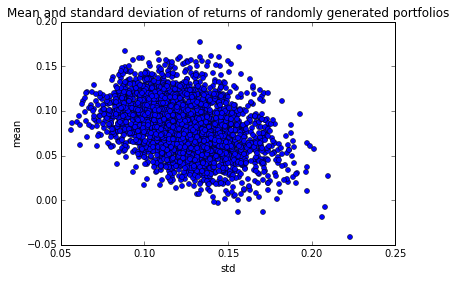

In [57]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios');
plt.show();

###### Solving optimization problem

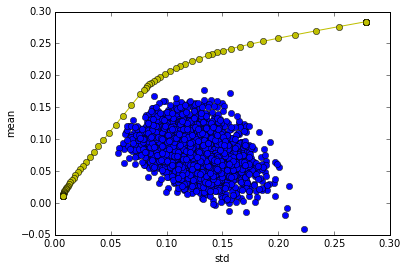

In [58]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)*252)
    pbar = opt.matrix(np.mean(returns, axis=1)*252)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    return returns, risks

returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o');

###### Market LIne

In [59]:
import scipy.interpolate as sci

In [60]:
def getListOfUniqueWithinPrecision(sortedArray):
    ind = 0
    currentVal = 0
    diffToIgnore = 0.00000001
    listOfIndices = [];
    for i in range(sortedArray.size):
        if(sortedArray[i] - diffToIgnore > currentVal):
            listOfIndices.append(i);
            currentVal = sortedArray[i];
    return listOfIndices;

In [61]:
twoRowsArrayForSorting = np.vstack([returns, risks]).T;
rowsAfterSorting = twoRowsArrayForSorting[twoRowsArrayForSorting[:,0].argsort()].T
returnsSorted = rowsAfterSorting[0,:];
risksSorted = rowsAfterSorting[1,:];
listOfInd = getListOfUniqueWithinPrecision(risksSorted);
print(listOfInd)
risksSorted  = risksSorted[listOfInd];
returnsSorted  = returnsSorted[listOfInd];
ind = np.argmin(risksSorted)
evols = risksSorted[ind:]
erets = returnsSorted[ind:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 89, 95, 99]


In [62]:
tck = sci.splrep(evols, erets)

In [63]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

In [64]:
def equations(p, rf=0.06):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [65]:
opt = sco.fsolve(equations, [0.06, 0.5, 0.15])

In [66]:
opt

array([ 0.06      ,  1.4872261 ,  0.08480495])

In [67]:
np.round(equations(opt), 5)

array([ 0.,  0.,  0.])

###### Show market line on graph

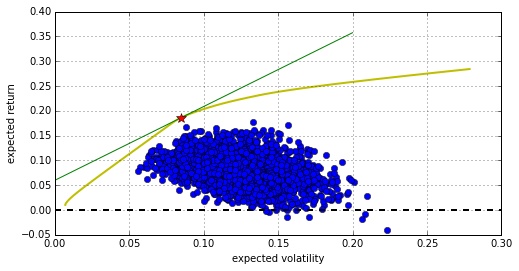

In [68]:
plt.figure(figsize=(8, 4))
plt.plot(stds, means, 'o')
            # random portfolio composition
plt.plot(evols, erets, 'y', lw=2.0)
            # efficient frontier
cx = np.linspace(0.0, 0.2)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.0)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=11.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')